In [1]:
import torch
import itertools
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader



In [2]:
def tsp_opt(points):
  """
  O(2^n*n^2)
  return optimal soalution
  """

  def length(x_coord, y_coord):
    return np.linalg.norm(np.asarray(x_coord)-np.asarray(y_coord))

  all_distances = [[length(x,y) for y in points] for x in points]
  A = {(frozenset([0, idx+1]),idx+1):(dist,[0,idx+1]) for idx, dist in enumerate(all_distances[0][1:])}
  cnt = len(points)
  for m in range(2,cnt):
    B={}
    for S in [frozenset(C)|{0} for C in itertools.combinations(range(1,cnt),m)]:
      for j in S - {0}:
        B[(S,j)]=min([(A[(S-{j},k)][0]+all_distances[k][j],A[(S-{j},k)][1]+[j])
          for k in S if k!=0 and k !=j])

    A = B
  res = min([(A[d][0]+ all_distances[0][d[1]],A[d][1]) for d in iter(A)])
  return np.asarray(res[1])





In [3]:
#dataset for trainning
class TSP_Dataset(Dataset):
  def __init__(self, data_size, citys_size):
    super(TSP_Dataset, self).__init__()
    self.data_size=data_size
    self.citys_size=citys_size
    self.data = self.get_data()

  def __len__(self):
    return self.data_size
  def __getitem__(self, idx):
    return {'Point':self.data['Point'][idx],'Solve':self.data['Solve'][idx]}
  def get_data(self):
    #generate dataset
    point = np.random.rand(self.data_size,self.citys_size,2)
    solve = [tsp_opt(citys)for citys in point]
    return dict(Point=point, Solve=solve)

In [4]:
#encoder model
class Encoder(nn.Module):
  def __init__(self, embedding_dim,hidden_dim, num_layers, dropout, bidirectional):
    super(Encoder,self).__init__()

    #initialize h0, c0
    self.num_layers = num_layers*2 if bidirectional else num_layers
    self.hidden_dim = hidden_dim //2 if bidirectional else hidden_dim

    self.lstm = nn.LSTM(
      input_size = embedding_dim,
      hidden_size = self.hidden_dim,
      num_layers = num_layers,
      batch_first = True,
      dropout = dropout,
      bidirectional = bidirectional)
    self.h0=Parameter(torch.zeros(1),requires_grad=False)
    self.c0=Parameter(torch.zeros(1),requires_grad=False)
  def forward(self,embedded_inputs):

    batch_size = embedded_inputs.size(0)
    h_0 =self.h0.unsqueeze(0).unsqueeze(0).repeat(self.num_layers,batch_size,self.hidden_dim)
    c_0 =self.c0.unsqueeze(0).unsqueeze(0).repeat(self.num_layers,batch_size,self.hidden_dim)
    output,(h_n,c_n)= self.lstm(embedded_inputs,(h_0,c_0))
    return output,(h_n,c_n)

In [5]:
#attention layer

class Attention(nn.Module):
  def __init__(self,hidden_dim):
    super(Attention, self).__init__()

    self.h_t_linear =nn.Linear(hidden_dim,hidden_dim)
    self.h_s_linear =nn.Conv1d(hidden_dim,hidden_dim,1,1)
    self.tanh =nn.Tanh()
    self.softmax = nn.Softmax()
    self.V =Parameter(torch.FloatTensor(hidden_dim),requires_grad=True)
    nn.init.uniform(self.V,-1,1)

    self._inf =Parameter(torch.FloatTensor([float('-inf')]),requires_grad = False)

  def forward(self, h_s, h_t, visited):
    #h_s 是encoder_output (N,L,Hidden)

    #score = V* tanh(W[h_s, h_t])
    h_s_ = self.h_s_linear(h_s.permute(0,2,1))
    h_t_ = self.h_t_linear(h_t).unsqueeze(2).expand(h_s.size(0),-1,-1)

    V=self.V.unsqueeze(0).unsqueeze(0).expand(h_s_.size(0),-1,-1)
    alpha =torch.bmm(V,self.tanh(h_s_+h_t_)).squeeze(1)
    #change visited city alpha to -inf, then softmax
    self.inf =self._inf.unsqueeze(1).expand(alpha.size(0),alpha.size(1))
    if len (alpha[visited])>0:
      alpha[visited]= self.inf[visited]
    alpha_=self.softmax(alpha)
    c_t =torch.bmm(h_s_, alpha_.unsqueeze(2)).squeeze(2)
    return c_t, alpha_

















In [6]:
#Decoder

class Decoder(nn.Module):
  def __init__(self, embedding_dim,hidden_dim):
    super(Decoder, self).__init__()

    self.embedding_dim =embedding_dim
    self.input0 =Parameter(torch.FloatTensor(embedding_dim),requires_grad=False)
    #decoder 's input initialised as random num in[-1,1]
    nn.init.uniform_(self.input0,-1,-1)

    self.i2h =nn.Linear(embedding_dim, 4*hidden_dim)
    self.h2h =nn.Linear(hidden_dim, 4*hidden_dim)

    self.att = Attention(hidden_dim)

    self.visited = Parameter(torch.zeros(1),requires_grad=False)

    self.Wc = nn.Linear(2*hidden_dim,hidden_dim)
    #city visited or not
    self.help_visited = Parameter(torch.zeros(1),requires_grad=False)
    self.sigmoid =nn.Sigmoid()
    self.tanh =nn.Tanh()

  def forward (self, embedded_inputs, decoder_h_0, decoder_c_0, encoder_output):
    batch_size = embedded_inputs.size(0)
    input_length = embedded_inputs.size(1)

    decoder_input = self.input0.unsqueeze(0).expand(batch_size,-1)

    decoder_h = decoder_h_0
    decoder_c = decoder_c_0

    visited = self.visited.unsqueeze(0).expand(batch_size, input_length)

    help_visited = self.help_visited.repeat(input_length)
    for i in range (input_length):
      help_visited.data[i]=i
    help_visited = help_visited.unsqueeze(0).expand(batch_size,-1).long()

    outputs = []
    pointers = []

    def step(x,h,c):
      #x=(N, embedding_dim), h=(N,Hidden), c=(N,Hidden)
      gates = self.i2h(x)+self.h2h(h)
      input,forget,cell,out = gates.chunk(4,1)

      forget = self.sigmoid(forget)
      input = self.sigmoid(input)
      cell = self.tanh(cell)
      out = self.sigmoid(out)

      c_t = (c * forget) + (input * cell)
      h_t = self.tanh(c_t)* out
      c_t,alpha = self.att(encoder_output,h_t, torch.eq(visited,1))
      hidden_t = self.tanh(self.Wc(torch.cat((c_t,h_t),1)))
      return hidden_t,c_t,alpha

    for _ in range(input_length):
      decoder_h,decoder_c,alpha = step(decoder_input, decoder_h, decoder_c)
      alpha_ = alpha * (1-visited)
      val, indices = alpha_.max(1)

      tmp = (help_visited == (indices.unsqueeze(1).expand(-1,input_length)))
      visited = 1-(1-visited)*(1-tmp.float())
      decoder_input = embedded_inputs[tmp.unsqueeze(2).expand (-1,-1,self.embedding_dim)].view(batch_size,self.embedding_dim)

      outputs.append(alpha_.unsqueeze(0))
      pointers.append(indices.unsqueeze(1))
    outputs = torch.cat(outputs).permute(1,0,2)
    pointers = torch.cat(pointers,1)
    return (outputs, pointers), (decoder_h,decoder_c)










In [7]:
class PtrNet(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, num_layers, dropout, bidirectionl):

    super(PtrNet, self).__init__()
    self.bidir = bidirectional
    self.embedding = nn.Linear(2,embedding_dim)
    self.encoder = Encoder(embedding_dim, hidden_dim, num_layers, dropout, bidirectional)
    self.decoder = Decoder(embedding_dim, hidden_dim)

  def forward(self, inputs):
    batch_size = inputs.size(0)
    seq_length = inputs.size(1)

    embedded_inputs = self.embedding(inputs.view(batch_size * seq_length, -1)).view(batch_size, seq_length,-1)
    encoder_output,(encoder_h_n, encoder_c_n)=self.encoder(embedded_inputs)

    if self.bidir:
      decoder_h = torch.cat(encoder_h_n[-2:],dim=-1)
      decoder_c = torch.cat(encoder_c_n[-2:],dim=-1)
    else:
      decoder_h = encoder_h_n[-1]
      decoder_c = encoder_c_n[-1]

    (outputs,pointers),(decoder_h,decoder_c)=self.decoder(embedded_inputs,decoder_h,decoder_c,encoder_output)
    return outputs, pointers






In [8]:
num_epochs = 500
train_size = 32
batch_size = 4
seq_length = 6
embedding_dim = 10
hidden_dim = 7
num_layers = 3
dropout = 0.2
lr = 0.001
bidirectional = False

In [9]:
myDataset = TSP_Dataset(train_size, seq_length)

myDataloader = DataLoader(dataset = myDataset, batch_size = batch_size, shuffle =True, num_workers = num_epochs)

mymodel = PtrNet(embedding_dim, hidden_dim, num_layers, dropout, bidirectional)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 500 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-5-fd61aeb7282f>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.V,-1,1)


In [10]:
CCE = torch.nn.CrossEntropyLoss()
mymodel_optim = optim.Adam(filter(lambda p: p.requires_grad, mymodel.parameters()),lr=lr)

In [11]:
for epoch in range(num_epochs):
  for i, item in enumerate(myDataloader):
    outputs, pointers = mymodel(item['Point'].float())
    outputs = outputs.contiguous().view(-1,outputs.size()[-1])
    target = item['Solve'].view(-1)
    loss = CCE(outputs,target)
    mymodel_optim.zero_grad()
    loss.backward()
    mymodel_optim.step()

    break
  break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 500 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/mo

In [12]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def train_model(model, dataloader, optimizer, num_epochs=2):
    model.train()
    loss_values = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            inputs = batch['Point'].float()
            targets = batch['Solve'].long()

            # Forward pass
            outputs, _ = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            total_loss += loss.item()  # Accumulate the loss

        average_loss = total_loss / len(dataloader)
        loss_values.append(average_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

    return loss_values

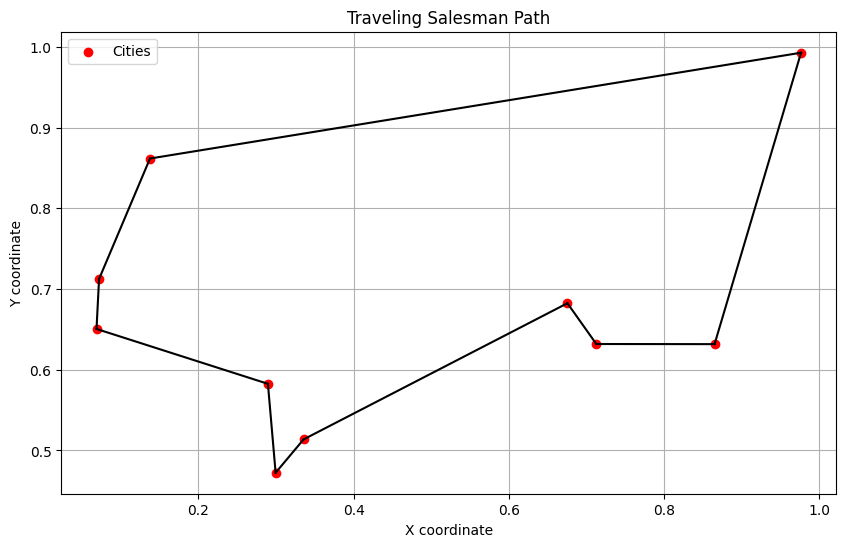

In [13]:
def visualize_tsp_solution(points, path,optimal_path=None):
    """
    Visualize the TSP solution path.

    Parameters:
    - points: A numpy array of shape (num_cities, 2), representing the coordinates of cities.
    - path: A list or array of indices representing the order of visited cities.
    """
    plt.figure(figsize=(10, 6))
    # Plot the points as red dots
    plt.scatter(points[:, 0], points[:, 1], c='red', label='Cities')

    # Draw lines between cities based on the path
    for i in range(1, len(path)):
        start_point = points[path[i-1]]
        end_point = points[path[i]]
        plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-')
    if len(path) > 0:
        plt.plot([points[path[-1], 0], points[path[0], 0]],
                 [points[path[-1], 1], points[path[0], 1]], 'k-')
    plt.title('Traveling Salesman Path')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()
dataset = TSP_Dataset(10, 10)
sample_index = 0  # Index of the sample to visualize
sample_data = dataset[sample_index]
points = sample_data['Point']
solution_path = sample_data['Solve']

# Assuming the solution is already in the correct format
visualize_tsp_solution(points, solution_path)

In [14]:
def plot_loss(loss_values):
    plt.figure(figsize=(10, 10))
    plt.plot(loss_values, label='Training Loss')
    plt.title('Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

<ipython-input-5-fd61aeb7282f>:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.V,-1,1)


Epoch [1/500], Loss: 1.7793
Epoch [2/500], Loss: 1.7517
Epoch [3/500], Loss: 1.7507
Epoch [4/500], Loss: 1.7541
Epoch [5/500], Loss: 1.7474
Epoch [6/500], Loss: 1.7370
Epoch [7/500], Loss: 1.7371
Epoch [8/500], Loss: 1.7280
Epoch [9/500], Loss: 1.7330
Epoch [10/500], Loss: 1.7192
Epoch [11/500], Loss: 1.7110
Epoch [12/500], Loss: 1.7056
Epoch [13/500], Loss: 1.6782
Epoch [14/500], Loss: 1.6743
Epoch [15/500], Loss: 1.6718
Epoch [16/500], Loss: 1.6714
Epoch [17/500], Loss: 1.6603
Epoch [18/500], Loss: 1.6513
Epoch [19/500], Loss: 1.6588
Epoch [20/500], Loss: 1.6347
Epoch [21/500], Loss: 1.6430
Epoch [22/500], Loss: 1.6472
Epoch [23/500], Loss: 1.6195
Epoch [24/500], Loss: 1.6313
Epoch [25/500], Loss: 1.6273
Epoch [26/500], Loss: 1.6382
Epoch [27/500], Loss: 1.6514
Epoch [28/500], Loss: 1.6271
Epoch [29/500], Loss: 1.6313
Epoch [30/500], Loss: 1.6374
Epoch [31/500], Loss: 1.6442
Epoch [32/500], Loss: 1.6431
Epoch [33/500], Loss: 1.6119
Epoch [34/500], Loss: 1.6290
Epoch [35/500], Loss: 1

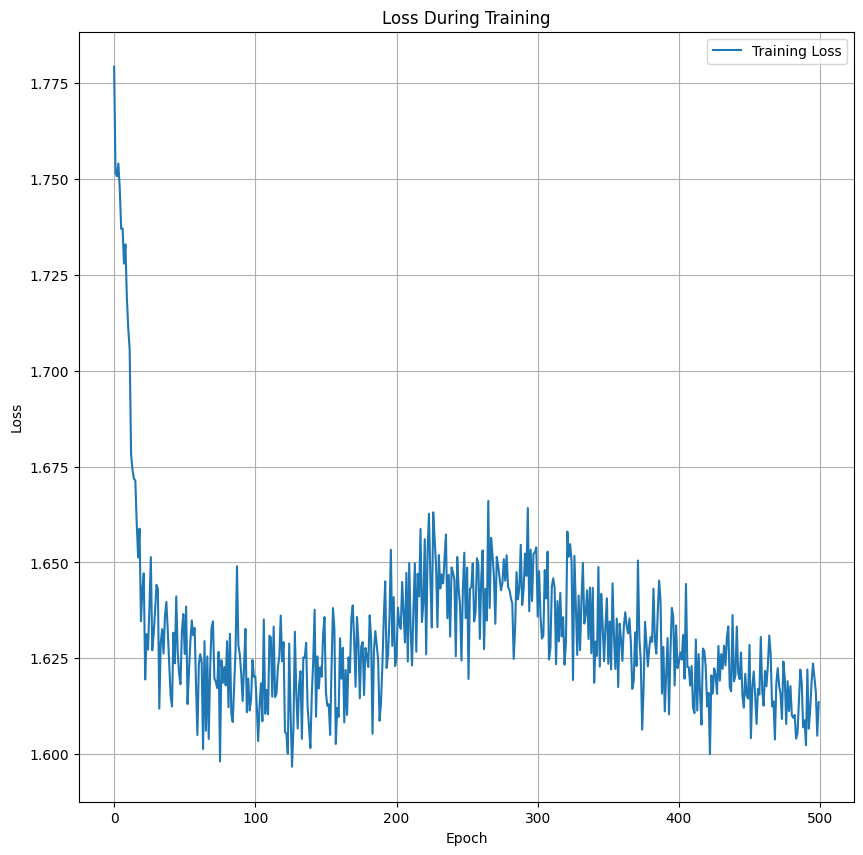

In [15]:


dataset = TSP_Dataset(train_size, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = PtrNet(embedding_dim, hidden_dim, num_layers, dropout, bidirectional)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
loss_values = train_model(model, dataloader, optimizer, num_epochs)

# Visualize the loss
plot_loss(loss_values)